In [2]:
import pyspark
from delta import *
from pyspark.sql import functions as F

builder = (
    pyspark.sql.SparkSession.builder.appName("MyApp")
    .master("local[*]")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.driver.memory", "5g")
    .config("spark.executor.memory", "5g")
    .config(
        "spark.sql.catalog.spark_catalog",
        "org.apache.spark.sql.delta.catalog.DeltaCatalog",
    )
    .config(
        "spark.jars.ivySettings",
        "../../ivy/2.4.0rc1.xml"
    )
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: file = ../../ivy/2.4.0rc1.xml
:: loading settings :: url = jar:file:/Users/nick.karpov/miniconda3/envs/pyspark-340-delta-240rc1/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/nick.karpov/.ivy2/cache
The jars for the packages stored in: /Users/nick.karpov/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fd79acad-55b2-4e23-846a-f8be49b631bb;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.4.0rc1 in custom
	found io.delta#delta-storage;2.4.0rc1 in custom
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 86ms :: artifacts dl 3ms
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |   0   |   0   ||   3   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-fd79acad-55b2-4e23

### MiniBench: DV vs. CoW as % of files touched increases

This example will show Delete w/ Deletion Vectors vs. traditional CoW as the number of files to rewrite increases progressively to a full table rewrite

In [3]:
from pyspark.sql.functions import expr, max, col
from dataclasses import dataclass
import time

In [4]:
table_path = "/tmp/tables/dvbench"

# write a 100m rows, evenly distributed into 100 files
# add a UUID column to beef up scan time
(spark.range(0,100000000, 1, 100)
     .withColumn("data", expr("uuid()"))
     .write
     .format("delta")
     .save(table_path))

23/05/25 12:11:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# enable Deletion Vectors table feature
spark.sql("ALTER TABLE delta.`%s` SET TBLPROPERTIES ('delta.enableDeletionVectors' = true)" % table_path)

DataFrame[]

In [6]:
@dataclass
class TestResult:
    files_touched: int
    run: str
    elapsed: float

def get_max_id_for_files(dt, numFiles):
    return list(map(lambda x: x.id, dt.toDF().groupBy(expr("input_file_name()").alias("file"))
        .agg(max("id").alias("id"))
        .limit(numFiles).select("id")
        .collect()))

In [7]:
dt = DeltaTable.forPath(spark, table_path)
files_to_touch = [1, 15, 30, 45, 60, 75, 90, 100]
num_runs_per_scenario = 3
results = []

In [11]:
for num_files in files_to_touch:
    for run in range(0, num_runs_per_scenario):
        print("Touching {} files, run {}".format(num_files, run))
        ids = get_max_id_for_files(dt, num_files) # get id's to delete
        
        start_time = time.time_ns()
        dt.delete(
            col("id").isin(ids)
        )
        end_time = time.time_ns()
        
        elapsed = end_time - start_time
        print("Took: {}".format(elapsed))
        results.append(TestResult(files_touched=num_files, run=run, elapsed=elapsed))

        dt.restoreToVersion(1)

Touching 1 files, run 0


Took: 2036234000
Touching 1 files, run 1


Took: 1356911000
Touching 1 files, run 2


Took: 1148696000
Touching 15 files, run 0


Took: 3149326000
Touching 15 files, run 1


Took: 3003812000
Touching 15 files, run 2


Took: 2902168000
Touching 30 files, run 0


Took: 2929830000
Touching 30 files, run 1


Took: 2875466000
Touching 30 files, run 2


Took: 2769846000
Touching 45 files, run 0


Took: 3342670000
Touching 45 files, run 1


Took: 3103026000
Touching 45 files, run 2


Took: 2942694000
Touching 60 files, run 0


Took: 2895487000
Touching 60 files, run 1


Took: 2834765000
Touching 60 files, run 2


Took: 3189980000
Touching 75 files, run 0


Took: 2919213000
Touching 75 files, run 1


Took: 3109613000
Touching 75 files, run 2


Took: 2721463000
Touching 90 files, run 0


Took: 2698260000
Touching 90 files, run 1


Took: 3023621000
Touching 90 files, run 2


Took: 2772167000
Touching 100 files, run 0


Took: 2639544000
Touching 100 files, run 1


Took: 2464915000
Touching 100 files, run 2


Took: 2635821000


In [12]:
results

[TestResult(files_touched=1, run=0, elapsed=2036234000),
 TestResult(files_touched=1, run=1, elapsed=1356911000),
 TestResult(files_touched=1, run=2, elapsed=1148696000),
 TestResult(files_touched=15, run=0, elapsed=3149326000),
 TestResult(files_touched=15, run=1, elapsed=3003812000),
 TestResult(files_touched=15, run=2, elapsed=2902168000),
 TestResult(files_touched=30, run=0, elapsed=2929830000),
 TestResult(files_touched=30, run=1, elapsed=2875466000),
 TestResult(files_touched=30, run=2, elapsed=2769846000),
 TestResult(files_touched=45, run=0, elapsed=3342670000),
 TestResult(files_touched=45, run=1, elapsed=3103026000),
 TestResult(files_touched=45, run=2, elapsed=2942694000),
 TestResult(files_touched=60, run=0, elapsed=2895487000),
 TestResult(files_touched=60, run=1, elapsed=2834765000),
 TestResult(files_touched=60, run=2, elapsed=3189980000),
 TestResult(files_touched=75, run=0, elapsed=2919213000),
 TestResult(files_touched=75, run=1, elapsed=3109613000),
 TestResult(files

In [13]:
table_path = "/tmp/tables/dvbench_nodv"

# write a 100m rows, evenly distributed into 100 files
# add a UUID column to beef up scan time
(spark.range(0,100000000, 1, 100)
     .withColumn("data", expr("uuid()"))
     .write
     .format("delta")
     .save(table_path))

In [14]:
dt = DeltaTable.forPath(spark, table_path)
files_to_touch = [1, 15, 30, 45, 60, 75, 90, 100]
num_runs_per_scenario = 3
results_nondv = []

In [15]:
for num_files in files_to_touch:
    for run in range(0, num_runs_per_scenario):
        print("Touching {} files, run {}".format(num_files, run))
        ids = get_max_id_for_files(dt, num_files) # get id's to delete
        
        start_time = time.time_ns()
        dt.delete(
            col("id").isin(ids)
        )
        end_time = time.time_ns()
        
        elapsed = end_time - start_time
        print("Took: {}".format(elapsed))
        results_nondv.append(TestResult(files_touched=num_files, run=run, elapsed=elapsed))

        dt.restoreToVersion(0)

Touching 1 files, run 0


Took: 1535278000
Touching 1 files, run 1


Took: 1326972000
Touching 1 files, run 2


Took: 1234699000
Touching 15 files, run 0


Took: 3408348000
Touching 15 files, run 1


Took: 3096041000
Touching 15 files, run 2


Took: 3148148000
Touching 30 files, run 0


Took: 4350453000
Touching 30 files, run 1


Took: 4148554000
Touching 30 files, run 2


Took: 4023096000
Touching 45 files, run 0


Took: 5583987000
Touching 45 files, run 1


Took: 5452527000
Touching 45 files, run 2


Took: 5582010000
Touching 60 files, run 0


Took: 6323857000
Touching 60 files, run 1


Took: 6245850000
Touching 60 files, run 2


Took: 6342403000
Touching 75 files, run 0


Took: 7728462000
Touching 75 files, run 1


Took: 7787085000
Touching 75 files, run 2


Took: 7628192000
Touching 90 files, run 0


Took: 8422210000
Touching 90 files, run 1


Took: 8540764000
Touching 90 files, run 2


Took: 8222059000
Touching 100 files, run 0


Took: 9277964000
Touching 100 files, run 1


Took: 9342659000
Touching 100 files, run 2


Took: 9454552000


In [53]:
import pandas as pd

# Convert to DataFrame
df_dv = pd.DataFrame([vars(result) for result in results])
df_nondv = pd.DataFrame([vars(result) for result in results_nondv])

grouped = df_dv.groupby(['files_touched'])['elapsed'].mean()
values_dv = grouped / 1e9

grouped = df_nondv.groupby(['files_touched'])['elapsed'].mean()
values_nondv = grouped / 1e9

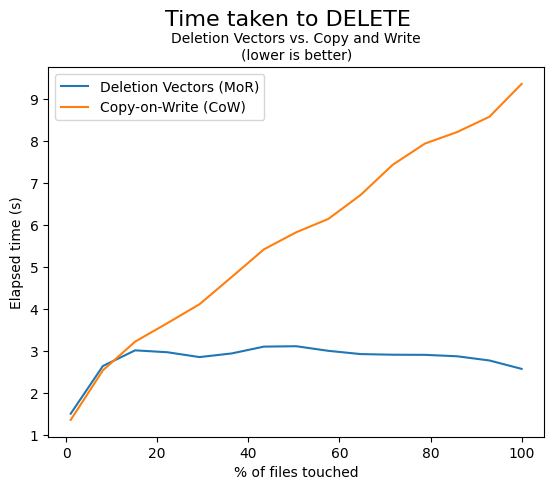

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

import pandas as pd

# use pandas to munge the results
df_dv = pd.DataFrame([vars(result) for result in results])
df_nondv = pd.DataFrame([vars(result) for result in results_nondv])

# get the average of the runs
grouped = df_dv.groupby(['files_touched'])['elapsed'].mean()
values_dv = grouped / 1e9

grouped = df_nondv.groupby(['files_touched'])['elapsed'].mean()
values_nondv = grouped / 1e9

# set up the data for matplotlib
number_of_files = np.array(files_to_touch)
elapsed_time_deletion_vectors = np.array(values_dv)
elapsed_time_no_deletion_vectors = np.array(values_nondv)

# smooth the data
xnew = np.linspace(number_of_files.min(), number_of_files.max(), 15)
spline_deletion_vectors = make_interp_spline(number_of_files, elapsed_time_deletion_vectors, k=3)(xnew)
spline_no_deletion_vectors = make_interp_spline(number_of_files, elapsed_time_no_deletion_vectors, k=3)(xnew)

# plot the data
plt.plot(xnew, spline_deletion_vectors, label="Deletion Vectors (MoR)")
plt.plot(xnew, spline_no_deletion_vectors, label="Copy-on-Write (CoW)")

# make it prettier and labels
plt.xlabel("% of files touched")
plt.ylabel("Elapsed time (s)")
plt.suptitle("Time taken to DELETE", fontsize=16, y=1.0)
plt.title("Deletion Vectors vs. Copy and Write\n(lower is better)", fontsize=10)
plt.legend()

# Show the chart
plt.show()